
**Install requirements**

In [ ]:
#!pip3 install 'torch==1.3.1' #changed 1.3.1
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'
#!pip3 install pretrainedmodels


**Import libraries**

In [ ]:
import os
import logging
import os.path
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, vgg16
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torchvision.datasets import VisionDataset
from collections import Counter
#import pretrainedmodels
from sklearn.preprocessing import LabelBinarizer


**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 32  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down #0.1 initally

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop( 64 , padding =2) ,
                                      #transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   # required normalization by alexnet and similar architectures                                 
])




In [ ]:





def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
  def __init__(self, root, split='train', transform=None, target_transform=None):
    super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

    self.split = split
    self.labels = []
    self.labels_idx = []
    self.images = []
    
          
    classes, class_to_idx = self._find_classes(self.root)

    self.classes = classes
    self.class_to_idx = class_to_idx

    splitp = "../" + split +".txt"
    filep= os.path.join(root, splitp)
  
    with open(filep, 'r') as splitfile:
      for line in splitfile:
        textlabel=line.split('/')[0].rstrip()
        if textlabel != 'BACKGROUND_Google':
          self.labels.append(textlabel)
          self.labels_idx.append(class_to_idx[textlabel])
          self.images.append(pil_loader(os.path.join(root, line.rstrip())))
        
      
  def _find_classes(self, dir):
        
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.remove('BACKGROUND_Google')
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx
    
    
  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels_idx[index]
      # Applies preprocessing when accessing the image
    if self.transform is not None:
      image = self.transform(image)

    return image, label

  def __len__(self):
    length = len(self.images)# Provide a way to get the length (number of elements) of the dataset
    return length

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Homework2-Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  

DATA_DIR = 'Homework2-Caltech101'
train_dataset=Caltech(DATA_DIR, transform=train_transform)
valid_dataset=Caltech(DATA_DIR, transform=eval_transform)
test_dataset=Caltech(DATA_DIR, transform=train_transform, split='test')

# Prepare Pytorch train/test Datasets

train_indexes = [idx for idx in range(len(train_dataset)) if idx % 2==0]  # use this method for splitting train set into 2 too
valid_indexes = [idx for idx in range(len(valid_dataset)) if idx % 2==1]  # as labels sorted in alphabetic order, class intstances are divided equally
                                                                          # between train and validation sets

valid_dataset= Subset(valid_dataset, valid_indexes)
train_dataset= Subset(train_dataset, train_indexes)
# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))
print('Validation Dataset: {}'.format(len(valid_dataset)))


Train Dataset: 2892
Test Dataset: 2893
Validation Dataset: 2892


**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


**Prepare Network**

In [ ]:
net = alexnet(pretrained=True) # Loading AlexNet model
#net= vgg16(pretrained=True) we can use another architecture too

# We need 101 outputs for Caltech-101

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
min_lost = 100.0
min_step=0
# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.classifier.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    
    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
      if(loss.item()<min_lost):
        min_lost=loss.item()
        min_step=current_step
      

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 
print(min_lost)
print(min_step)

**Test**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

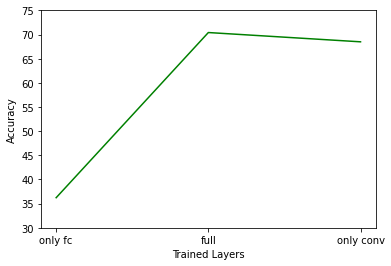

In [ ]:
acc_10 = [36.23, 70.41, 68.49]
acc_1 = [64.37, 69.00, 66.58]

test_epoch = ["30", "50", "80"]
test_layer = ["only fc", "full", "only conv"]


plt.plot(test_layer, acc_10, 'g')
#plt.plot(test_epoch, acc_1, 'g', label='With 0.001 learning rate')
x1,x2,y1,y2 = plt.axis()

plt.axis((x1,x2,30,75))
plt.xlabel('Trained Layers')
plt.ylabel('Accuracy')
#plt.legend()
plt.show()